# Data Processing

This notebook details the basic and advanced cleaning of the data. 

The data I am using is called the "Enron Corpus," a collection of 500,000+ emails from the infamous investing firm that crashed in the early 2000s. 

You can find the data here: https://www.cs.cmu.edu/~./enron/

### Description of data

The csv file contains just one column with all the relevant data captured in a string. The relevant types of data include:

* **Date:** Date email was sent 
* **From:** The email address of the sender 
* **To:** The email address of the receiver 
* **Message-Body:** The content within the email 

Other information includes CC, BCC, relevant filenames, and more. 

# Setup

In [1]:
# Load timer
%load_ext autotime

In [12]:
# Import necessary libraries 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
#nltk.download()
import re


# Turn off warnings
import warnings 
warnings.simplefilter('ignore')

time: 1.36 s


In [3]:
# Read in csv file 
emails = pd.read_csv("emails.csv")

time: 11.1 s


In [4]:
# Preview the data
emails.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


time: 13.8 ms


In [5]:
# Get shape
emails.shape

(517401, 2)

time: 2.22 ms


# Basic Cleaning

In [6]:
# Slice data at relevant position and create a new column in data frame
emails['Date'] = emails.message.str.split("\n").str[1].str[6:]
emails['From'] = emails.message.str.split("\n").str[2].str[6:]
emails['To'] = emails.message.str.split("\n").str[3].str[4:]
emails['Subject'] = emails.message.str.split("\n").str[4].str[9:]
emails['Message-Body'] = emails.message.str.split('\n').str[16:].str.join('')

time: 56.8 s


In [8]:
# Create new dataframe and convert to datetime format
emails_cleaned = emails[['Date', 'From', 'To', 'Subject', 'Message-Body']]
emails_cleaned['Date'] = pd.to_datetime(emails_cleaned['Date']).dt.date

time: 1min 29s


In [9]:
# Preview 
emails_cleaned.head()

,Date,From,To,Subject,Message-Body
0,2001-05-14,phillip.allen@enron.com,tim.belden@enron.com,,Here is our forecast
1,2001-05-04,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...
2,2000-10-18,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!
3,2000-10-23,phillip.allen@enron.com,randall.gay@enron.com,,"Randy, Can you send me a schedule of the salar..."
4,2000-08-31,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.


time: 13.6 ms


In [11]:
# Get shape
emails_cleaned.shape

(517401, 5)

time: 2.32 ms


In [10]:
# Write to csv as checkpoint
# emails_cleaned.to_csv('emails_v1.csv')

time: 23.4 s


In [13]:
# Drop unecessary columns
try:
    emails_cleaned = emails_cleaned.drop(['To', 'Subject'], axis=1)
except:
    pass

time: 303 ms


# Process Email Messages

In [14]:
# Function to clear out junk keywords and only save original emails

bad_keywords = ['X-cc:', 'Outlook Migration Team@', 'X-FileName:', 'X-Origin:', 'X-Folder:', 'X-To: ', 'X-bcc:' ]
def clean_startswith(df, keyword):
    df = df[ df['Message-Body'].str[0:len(keyword)] != keyword ]
    return df

# Execute funtion
original_emails = emails_cleaned.copy()

for keyword in bad_keywords:
    original_emails = clean_startswith(original_emails, keyword)

original_emails.head()

,Date,From,Message-Body
0,2001-05-14,phillip.allen@enron.com,Here is our forecast
1,2001-05-04,phillip.allen@enron.com,Traveling to have a business meeting takes the...
2,2000-10-18,phillip.allen@enron.com,test successful. way to go!!!
3,2000-10-23,phillip.allen@enron.com,"Randy, Can you send me a schedule of the salar..."
4,2000-08-31,phillip.allen@enron.com,Let's shoot for Tuesday at 11:45.


time: 1.84 s


In [15]:
# Preview 
original_emails.shape

(393753, 3)

time: 2.43 ms


In [17]:
# Get rid of additional messages that are forwarded
original_emails['Message-Body'] = original_emails['Message-Body'].str.split('----').str[0]

time: 2.32 s


In [18]:
# Calculate the length of each email 
original_emails['Verbosity'] = original_emails['Message-Body'].str.count(' ')

original_emails.head()

,Date,From,Message-Body,Verbosity
0,2001-05-14,phillip.allen@enron.com,Here is our forecast,4
1,2001-05-04,phillip.allen@enron.com,Traveling to have a business meeting takes the...,146
2,2000-10-18,phillip.allen@enron.com,test successful. way to go!!!,5
3,2000-10-23,phillip.allen@enron.com,"Randy, Can you send me a schedule of the salar...",34
4,2000-08-31,phillip.allen@enron.com,Let's shoot for Tuesday at 11:45.,7


time: 4.56 s


In [20]:
# Take out all emails with no words and those above 400 

original_emails = original_emails[ original_emails['Verbosity'] > 0]
original_emails = original_emails[ original_emails['Verbosity'] < 400]

# Filter out some additional junk emails 

original_emails = original_emails[ original_emails['From'].str[-10:] == '@enron.com' ] #Not from enron employee
original_emails = original_emails[ original_emails['From'] != 'center.ets@enron.com' ] #Not from alert system
original_emails = original_emails[ original_emails['Message-Body'].str.strip() != ''] #Is just a space 


original_emails.sort_values('Verbosity', ascending=False)

,Date,From,Message-Body,Verbosity
485284,1999-07-23,mark.taylor@enron.com,>> Day 752>> My captors continue to taunt me w...,399
30261,2000-12-07,nicki.daw@enron.com,"\tshawn.cumberland@enron.com, dan.leff@enron.c...",399
386610,2001-08-27,ipayit@enron.com,"\tsally.mcadams@enron.com, michael.desbiens@en...",399
394863,2000-09-20,richard.sanders@enron.com,Lunch as you proposed sounds good. Thanks in a...,399
111022,2000-03-06,daren.farmer@enron.com,"Hey Ken,Sorry it has taken so long to get back...",399
398273,2001-06-11,richard.sanders@enron.com,Disregard my previous messageabout this case. ...,399
453198,2000-07-22,carol.clair@enron.com,Rod:Thanks for the info. Our family doctor ha...,399
69827,2001-09-25,ginger.dernehl@enron.com,"\tjanel.guerrero@enron.com, allison.hamilton@e...",399
101574,2000-03-06,daren.farmer@enron.com,"Hey Ken,Sorry it has taken so long to get back...",399
393737,2001-06-11,richard.sanders@enron.com,Disregard my previous messageabout this case. ...,399


time: 524 ms


After cleaning, the df has this number of emails:  254377


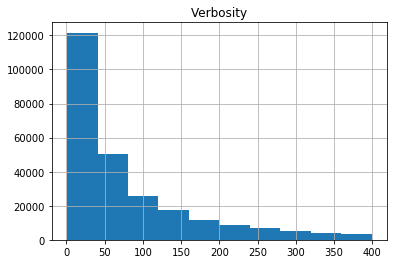

time: 217 ms


In [21]:
#Plot the distribution of words in each email and shape of data

original_emails.hist(column='Verbosity')

print ("After cleaning, the df has this number of emails: ", original_emails.shape[0])

# Advanced Data Processing

- All words to lowercase 
- Remove punctuation
- Remove stop words with nltk
- Remove numbers
- Remove non-english words with nltk corpus
- Apply lemmatizer 

In [22]:
# Lower

original_emails['Message-Body'] = original_emails['Message-Body'].str.lower()

time: 305 ms


In [23]:
# Remove punctuation w/ regex

original_emails["Message-Body"] = original_emails['Message-Body'].str.replace('[^\w\s]',' ')

time: 5.31 s


In [24]:
# Remove stop words with NLTK

stop = stopwords.words('english')
original_emails['Message-Body'] = original_emails['Message-Body'].apply(lambda x: ' '.join({word for word in x.split() if word not in (stop)}))

time: 47.2 s


In [25]:
# Remove numbers 

original_emails["Message-Body"] = original_emails['Message-Body'].str.replace('\d+', '')

time: 2.49 s


In [26]:
# Still have words in not the english language. Remove them 

english_words = set(nltk.corpus.words.words())

original_emails['Message-Body'] = original_emails['Message-Body'].apply(lambda x: ' '.join({word for word in x.split() if word in (english_words)}))

time: 2.92 s


In [27]:
# Now remove rows that no longer have values 

original_emails = original_emails[ original_emails['Message-Body'].str.strip() != '']

time: 152 ms


In [28]:
# Apple Lemmatizer

from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

original_emails['Message-Body'] = original_emails['Message-Body'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

time: 26.8 s


In [29]:
# Recalculate Verbosity

original_emails['Verbosity'] = original_emails['Message-Body'].str.count(' ')

time: 480 ms


In [31]:
# Preview

original_emails.head()

,Date,From,Message-Body,Verbosity
0,2001-05-14,phillip.allen@enron.com,forecast,0
1,2001-05-04,phillip.allen@enron.com,better turn honest far suggestion waiting nece...,51
2,2000-10-18,phillip.allen@enron.com,successful way go test,3
3,2000-10-23,phillip.allen@enron.com,made example need everyone schedule salary sen...,10
4,2000-08-31,phillip.allen@enron.com,shoot let,1


time: 8.49 ms


After advanced cleaning, the df has this number of emails:  249474


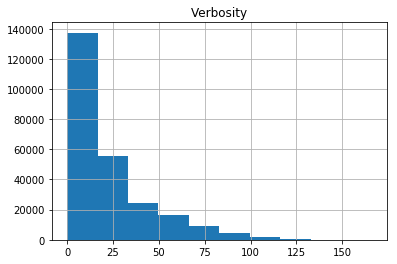

time: 189 ms


In [32]:
# New histogram

original_emails.hist(column='Verbosity')

print ("After advanced cleaning, the df has this number of emails: ", original_emails.shape[0])

In [33]:
# Write to csv as checkpoint

# original_emails.to_csv('emails_v2.csv')

time: 1.86 s
